# Registering MagAO-X images when the star is saturated
Written by Logan Pearce, 2024, www.loganpearce.com



When a star is saturated on the detector, the exact center of the star and the total flux from the star can't be determined, since the photon buckets overflowed.

Let's load two example imagaes, one where the star saturated the detector and one where it did not.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(500.0, 600.0)

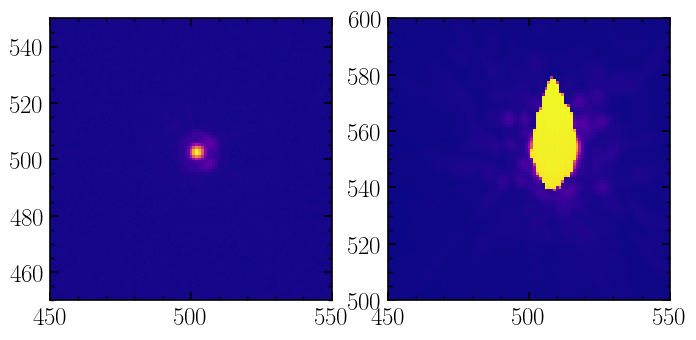

In [2]:
unsat = fits.getdata('unsat.fits').astype('=f8')
sat = fits.getdata('sat.fits').astype('=f8')

fig,axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(unsat, origin='lower')
axes[0].set_xlim(450,550)
axes[0].set_ylim(450,550)
axes[1].imshow(sat, origin='lower')
axes[1].set_xlim(450,550)
axes[1].set_ylim(500,600)

Here we plot a slice of the image through the center of the star (noramlized b/c we don't care about flux values here) for each image.

Text(0.5, 0, 'Pixel')

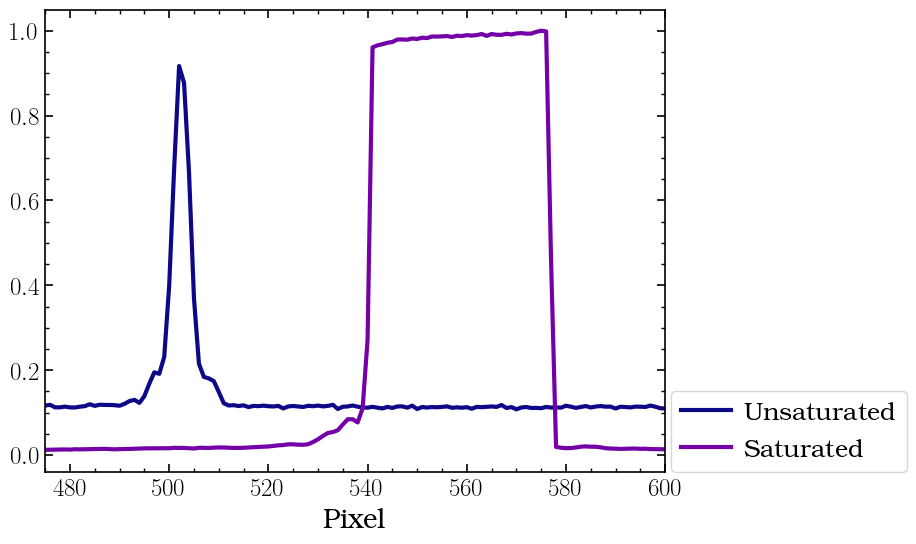

In [3]:
plt.plot(range(unsat.shape[0]),unsat[:,503]/np.max(unsat), label='Unsaturated')
plt.plot(range(sat.shape[0]),sat[:,510]/np.max(sat), label='Saturated')
plt.legend(loc=(1.01,0))
plt.xlim(475,600)
plt.xlabel('Pixel')

The profile for the saturated star is cut off, making it impossible to fit a 2D Gaussian or use peak finding to find the location of the star.  To register (center) these images for future analysis, we need another way to find the exact location of the star on the detector.

MagAO-X images have symmetric spikey speckles caused by the deformable mirror. They're always there, always in the same place relative to star (as a function of the filter wavelength).  We can use these DM spikes to find the exact location of the star on the detector and register the images.  We will use the four brightest speckles seen in this stretch of the saturated image.

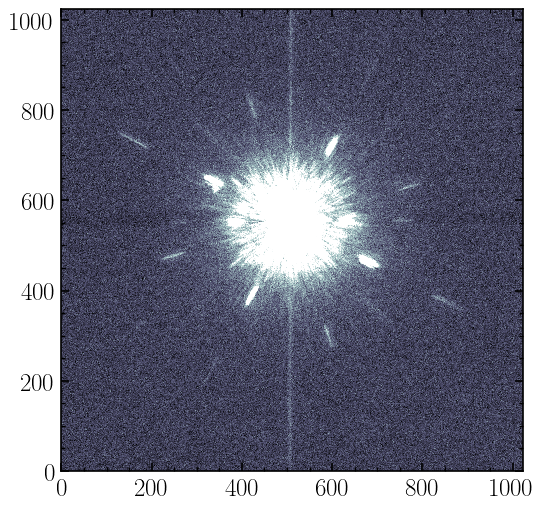

In [4]:
from astropy.visualization import ImageNormalize, ZScaleInterval
norm = ImageNormalize(sat, interval=ZScaleInterval())
plt.imshow(sat, cmap='bone', norm=norm, origin="lower")

We will use the following procedure to find the center of the star:
 - 1. Find the approximate location of the star
 - 2. Mask the rest of the image except the four DM spikes
 - 3. Fit a 2d Gaussian to each spike
 - 4. Take the average (x,y) of each fitted Gaussian as the star center
 - 5. Repeat for each image in a dataset
 - 6. Register images

## 1: Find the approximate location of the star

We need an initial guess in order to refine the star location. Fortunately close is good enough for this part. 

There's lots of ways to go about this.  We could take a center of mass approach and take a weighted sum of x and y coordinates with the pixel value as the weights:

In [5]:
x = []
y = []
# For each x sum, sum the column of pixels with that x-corrd:
for i in range(sat.shape[1]):
    x.append(np.sum(sat[:,i]))
# Take the weighted sum as the x-value estimator:
xbar = np.sum(x * np.arange(sat.shape[1])) / np.sum(x)
# repeat for y:
for j in range(sat.shape[0]):
    y.append(np.sum(sat[j,:]))
ybar = np.sum(y * np.arange(sat.shape[0])) / np.sum(y)
print(xbar, ybar)

511.4620477943499 514.2704554616723


Hm, the weighted average didn't seem to work, since the star is closer to (510,560), as seen in the first plot.

But if we take the location of the max values of these sums, it gets pretty close:

[508] [553]


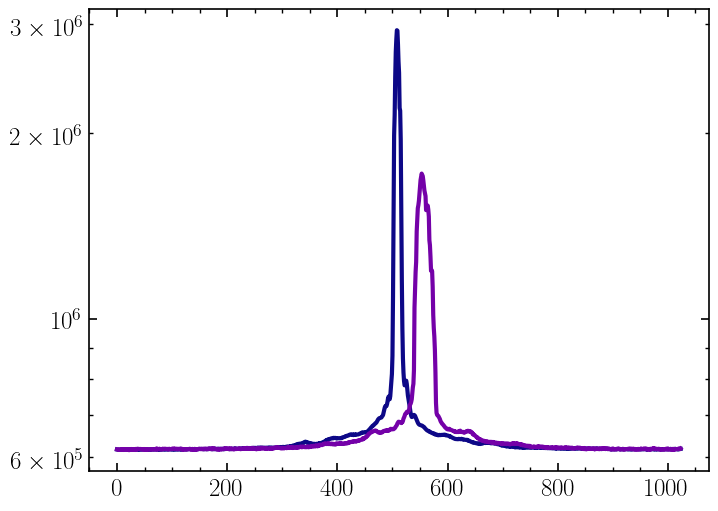

In [6]:
plt.plot(range(len(x)),x)
plt.plot(range(len(y)),y)
xsummax, ysummax = np.where(x == max(x))[0], np.where(y == (max(y)))[0]
print(xsummax, ysummax)
plt.gca().set_yscale('log')

Photutils also has a set of centroid functions we can use.  Let's see how they all compare

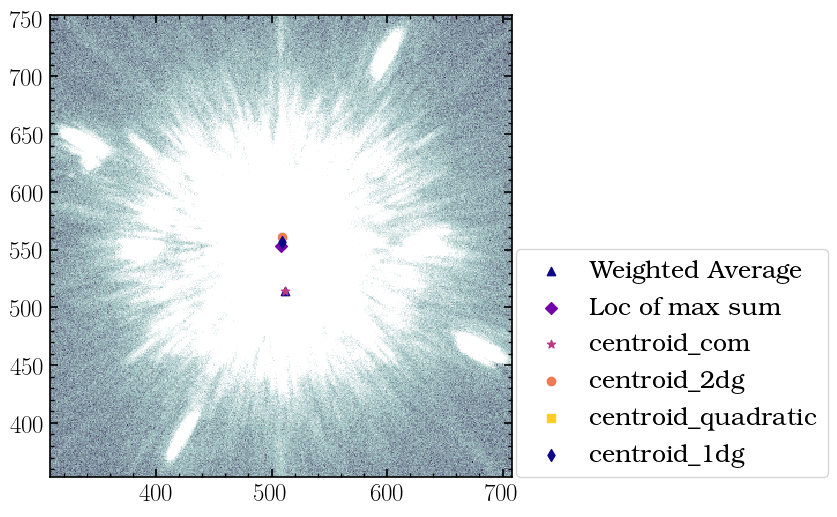

In [7]:
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)


plt.figure()
norm = ImageNormalize(sat, interval=ZScaleInterval(),
                      stretch=SqrtStretch())
plt.imshow(sat, cmap='bone', norm=norm, origin='lower')
plt.scatter(xbar,ybar, marker='^', label='Weighted Average')
plt.scatter(xsummax, ysummax, marker='D', label='Loc of max sum')
x1, y1 = centroid_com(sat)
plt.scatter(x1,y1, marker='*', label='centroid_com')
x1, y1 = centroid_2dg(sat)
plt.scatter(x1,y1, marker='o', label='centroid_2dg')
x1, y1 = centroid_quadratic(sat)
plt.scatter(x1,y1, marker='s', label='centroid_quadratic')
x1, y1 = centroid_1dg(sat)
plt.scatter(x1,y1, marker='d', label='centroid_1dg')

l = 200
plt.xlim(xsummax-l, xsummax+l)
plt.ylim(ysummax-l,ysummax+l)
plt.legend(loc=(1.01,0))
plt.show()

Looks like both my and photutils' center of mass estimates are way off, and the quadratic function returned nans, but the other three seem pretty reliable.  We don't have to get exact here, but we do need to be able to return the correct approximate location of the star regardless of where it lands on the detector. So I recommend using photutils 1dg or 2dg centroid function.

## 2: Mask everything but the DM spikes

Now that we know about where the star is, we need to find the *exact* subpixel location using the DM spikes. We will do this by fitting a 2D Gaussian to each spike and taking the average (x,y) location.  But first we want to mask everything but the DM spikes in the image, so the fitter doesn't walk away.

So first we will make a new array on which to build the mask which is the same shape as the image and fill it with either zeros or nans. I've found that when I used zeros the fitter still tended to walk off into the zeroed areas, so I will use nans.mask = np.zeros(im.shape)

In [8]:
mask = np.empty(sat.shape) * np.nan

Now we need to cut out the areas between the spikes. That means we need to know the angle of the spikes and each pixel. The spikes are all 90 deg from each other, and the first spike (going couterclockwise from 12 o'clock) is about 62 degrees. I figured this just trial and error and it isn't exact, so adjust things if you feel necessary.

In [9]:
# First get the approximate location of the star:
center = centroid_2dg(sat)
# Use the meshgrid function to create a grid of pixels that is the shape of the image but centered on the star
xx,yy = np.meshgrid(np.arange(sat.shape[0])-center[0],np.arange(sat.shape[1])-center[1])

In [10]:
# Initial guess:
pa0 = 62
# Make an array of position angles from there:
pas = [pa0, pa0+90, pa0+180, pa0+270]

We need to find the angle of each pixel in the mask, which we can use the meshgrid and the arctan2 function, which computes inverse tangent but retains the appropriate quadrant of the unit circle

In [11]:
angle = np.arctan2(yy,xx)
# We established pa as ccw from 12 o'clock (typical for sky images(, but numpy uses the unit circle convention where angles 
# move ccw from 3 o'clock (+x axis), so we need to adjust the arctan to 0 being the +y axis:
angle = (np.degrees(angle) + 270)%360

Now for each position angle, set all pixles within a window of angles to 1.

In [12]:
window_width = 6
for i in range(len(pas)):
    phi0 = pas[i] - window_width
    phi1 = pas[i] + window_width
    mask[np.where((angle > phi0) & (angle < phi1))] = 1

Let's check our work by looking at the saturated image times the mask

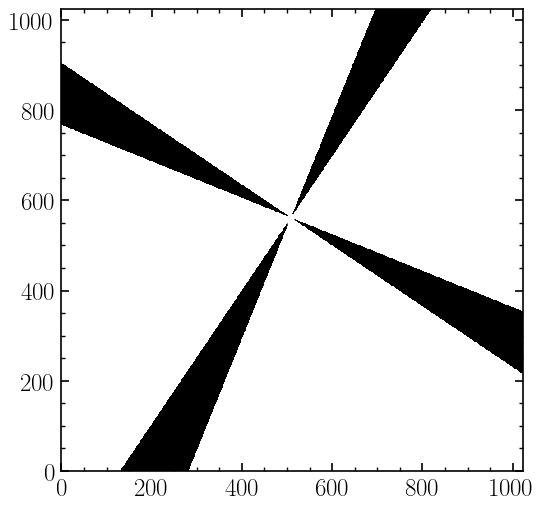

In [13]:
plt.figure()
plt.imshow(sat*mask, cmap='bone', origin='lower')#, norm=norm)

Now we need to find all the pixels in an annulus surrounding the star that encompasses the spikes and keep those pixels in the mask while setting the outside pixels back to nan. This means we need to know the distance of each pixel from the star so we can find which ones to keep. We can use the same meshgrid funrction from before.

In [14]:
# Compute the radial distance of each pixel from the center:
r=np.hypot(xx,yy)

We need to decide how big to make the annulus. The spikes look to be about 200 pixels from star, so I'll set an inner and outer radius that approximate encloses them. You can play around with these settings until you get an annulus that gets the whole spike but not too much inside and outside it.

In [15]:
r_in = 160
r_out = 230

# Find which pixels are outside the inner radius and set them to nan:
inner = np.where(r<r_in)
mask[inner] = np.nan
#Now find pixels outside the outer radius and set them back to nan:
outer = np.where(r>r_out)
mask[outer] = np.nan

(300.0, 800.0)

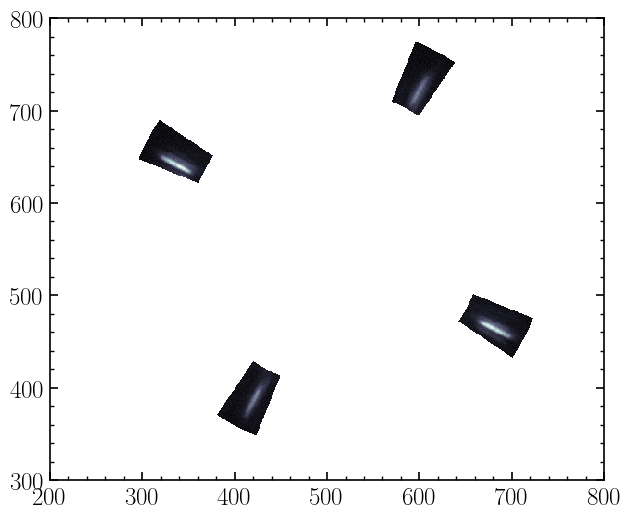

In [16]:
plt.figure()
plt.imshow(sat*mask, cmap='bone', origin='lower')
plt.xlim(200,800)
plt.ylim(300,800)

Ok I like that. I also cut out the little point sources next to the first spike which we dont want influencing the fit. I think this will be good enough to keep the fitter from walking off into other regions of the image.

## 3: Find the exact location of the spikes by fitting a 2d Gaussian

We will use astropy's 2d Gaussian model and fitter, but first we need to give the fitter some initial guesses for parameters.  We already have an initial guess for the (x,y) position from the radial and angular masking process.## 2: Mask everything but the DM spikes

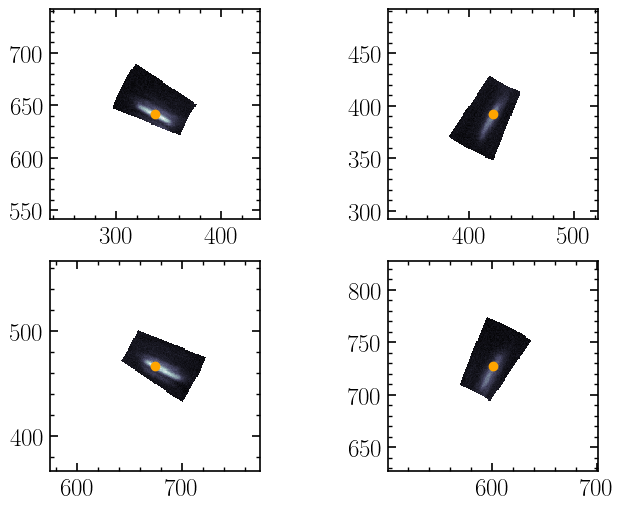

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)


pa0 = 62
pas = [pa0+3, pa0+90+1, pa0+180-1.8, pa0+270-1]
# Initial guess for radial distance:
r = 190
# for each spike:
for i in range(4):
    ax = axes.flatten()[i]
    # show the masked region around the spike:
    axes.flatten()[i].imshow(sat*mask, cmap='bone', origin='lower')
    # compute x and y from the radial and angular location:
    spikex = - r * np.sin(np.radians(pas[i]))
    spikey = r * np.cos(np.radians(pas[i]))
    # let's plot it and see how we did:
    actualx = spikex + center[0]
    actualy = spikey + center[1]
    axes.flatten()[i].scatter(actualx, actualy, color='orange')
    ax.set_xlim(actualx - 100,actualx + 100)
    ax.set_ylim(actualy - 100,actualy + 100)

If you see in the pas array I did some adjusting the get the spot to land right on the spike.  It might take some trial and error.

Now let's take the first spike and make a model

In [18]:
# Compute the (x,y) initial guess:
i = 0
spikex = - r * np.sin(np.radians(pas[i]))
spikey = r * np.cos(np.radians(pas[i]))
actualx = spikex + center[0]
actualy = spikey + center[1]

# I'm going to cut out just the spike I'm interested in:
imcutmask = (sat*mask)[int(actualy - 100):int(actualy + 100),int(actualx - 100):int(actualx + 100)]
# For the amplitude initial guess I'll use the maximum pixel value in this cut:
amplitude = np.nanmax(imcutmask)
# The x and y std dev sets the Gaussian elongation in x and y axes. This spike is very long in one axis and short in the other. 
# I used trial and error to find the ratio is about 8/2
x_stddev = 8
y_stddev = 2
# Finally the theta parameter sets the rotation from zero about the center for the gaussian
theta = -np.radians(pas[i])

from astropy.modeling.functional_models import Gaussian2D, Planar2D
model = Gaussian2D(amplitude = amplitude,
                   x_mean = actualy,
                   y_mean = actualx,
                   x_stddev = x_stddev,
                   y_stddev = y_stddev,
                   theta = theta
                  )


Notice x and y have to be switched here. Python uses (row,column) notation which means what we've called x actualy goes in the y spot and v.v.  Keep this in mind whenever wroking with images in python!

Now this model goes to zero at the edges, but our image doesn't have zero values beyond the spikes due to background levels in the image.  So to get a good fit we need to also make a model of the background and add it to our Gaussian in order to fit correctly. I'm going to grab an area of the image far away from the star and other speckles and take the median as the background level.

603.0

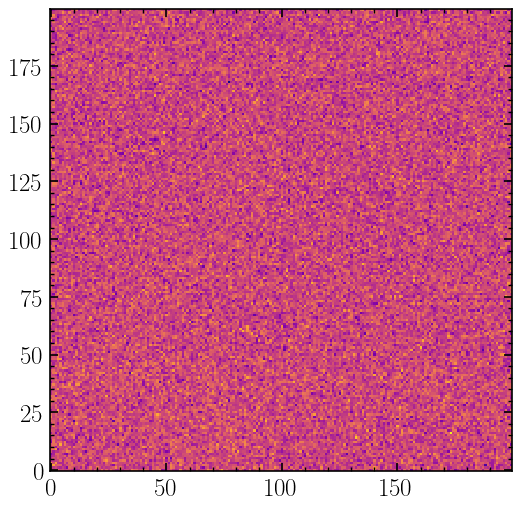

In [19]:
bkgd = sat[800:1000, 800:1000]
%matplotlib inline
plt.imshow(bkgd, origin='lower')
bkgd = np.nanmedian(bkgd)
bkgd

We can use astropy's Planar2D model the make a constant offset at the background level and add it to the Gaussian model.

In [20]:
# We want a flat plane so no slope in x or y direction:
model2 = Planar2D(slope_x = 0, slope_y = 0, intercept = bkgd)


To create a model image using these models, we need to project them onto a grid of the same size as the image

In [21]:
# Make meshgrid:
xx,yy = np.mgrid[:sat.shape[0],:sat.shape[1]]
# Project each model onto the mesh grid and add them together to make a complete spike model.
modelim = model(xx,yy) + model2(xx,yy)


Let's see how it looks

Text(0.5, 1.0, 'Data -  Model')

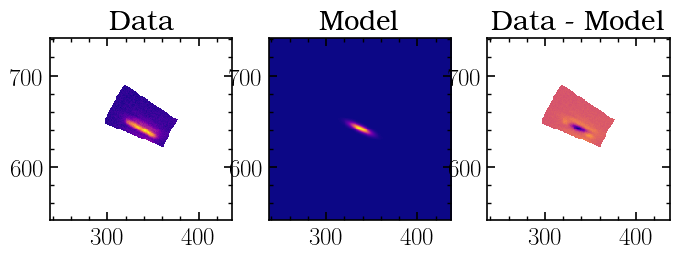

In [22]:

fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(sat*mask, origin='lower')
l = 100
axes[0].set_xlim(actualx - l,actualx + l)
axes[0].set_ylim(actualy - l,actualy + l)
axes[0].set_title('Data')
axes[1].imshow(modelim, origin='lower')
axes[1].set_xlim(actualx - l,actualx + l)
axes[1].set_ylim(actualy - l,actualy + l)
axes[1].set_title('Model')
axes[2].imshow(sat*mask - model(xx,yy), origin='lower')
axes[2].set_xlim(actualx - l,actualx + l)
axes[2].set_ylim(actualy - l,actualy + l)
axes[2].set_title('Data -  Model')

Hm ok not that great, but it's just an initial guess.  Let's hope the fitter does a better job.

We can use Astropy fitting functions. I found that the Trust Region Reflective least-squares fitter did a better for here than the Levenberg-Marquardt fitter. The fitters don't take nan's, so we'll feed it only the finite valued pixels.

In [23]:
from astropy.modeling import fitting
#fitter = fitting.LMLSQFitter()
fitter = fitting.TRFLSQFitter()

# Sum the two models:
model_to_fit = model+model2
# Feed into the fitter only the finite-values pixels.
data_to_fit = sat[~np.isnan(mask)]
# and the pixel locations of the finite-values pixels
x_to_fit = xx[~np.isnan(mask)]
y_to_fit = yy[~np.isnan(mask)]

fit = fitter(model_to_fit, x_to_fit, y_to_fit, data_to_fit)

In [24]:
# let's see what it came up with:
fit

<CompoundModel(amplitude_0=516.83598137, x_mean_0=641.15189938, y_mean_0=337.84638693, x_stddev_0=12.70565712, y_stddev_0=3.20447351, theta_0=-1.08489845, slope_x_1=-0.07606007, slope_y_1=0.12079754, intercept_1=640.66970912)>

We can see the 2d Gaussian parameters with '0' subscripts and the Planar parameters with '1' subscripts because we fed it two models to fit. And the final values are different than the inputs with no errors so the fitter succeeded in finding a better fit than out initial guesses.  Let's see how it did.

Text(0.5, 1.0, 'Data -  Model')

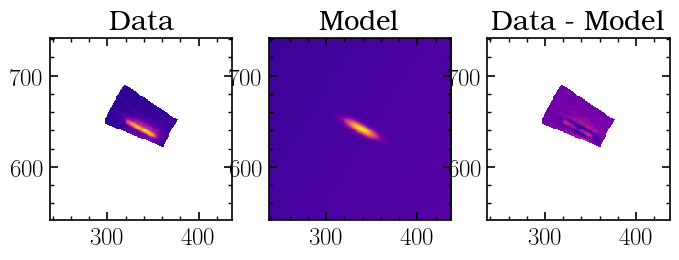

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].imshow(sat*mask, origin='lower')
l = 100
axes[0].set_xlim(actualx - l,actualx + l)
axes[0].set_ylim(actualy - l,actualy + l)
axes[0].set_title('Data')
axes[1].imshow(fit(xx,yy), origin='lower')
axes[1].set_xlim(actualx - l,actualx + l)
axes[1].set_ylim(actualy - l,actualy + l)
axes[1].set_title('Model')
axes[2].imshow(sat*mask - fit(xx,yy), origin='lower')
axes[2].set_xlim(actualx - l,actualx + l)
axes[2].set_ylim(actualy - l,actualy + l)
axes[2].set_title('Data -  Model')

Ooh that looks much better.  Nice job fitter.

Ok now we need to repeat that for all of the spikes.

In [26]:
from astropy.modeling.functional_models import Gaussian2D, Planar2D
# Create empty lists to store results:
xs = []
ys = []
# for each spike angle:
for i,pa in enumerate(pas):
    spikex = - r * np.sin(np.radians(pas[i]))
    spikey = r * np.cos(np.radians(pas[i]))
    actualx = spikex + center[0]
    actualy = spikey + center[1]
    imcutmask = (sat*mask)[int(actualy - 100):int(actualy + 100),int(actualx - 100):int(actualx + 100)]
    model = Gaussian2D(amplitude = np.nanmax(imcutmask),
                       x_mean = spikey + center[1],
                       y_mean = spikex + center[0],
                       x_stddev = 8,
                       y_stddev = 2,
                       theta = -np.radians(pas[i])
                      )
    model2 = Planar2D(slope_x = 0, slope_y = 0, intercept = bkgd)
    fit = fitter(model+model2, xx[~np.isnan(mask)], yy[~np.isnan(mask)], sat[~np.isnan(mask)])
    # switching x and y again:
    xs.append(fit.y_mean_0.value)
    ys.append(fit.x_mean_0.value)

In [27]:
xs,ys

([337.84638693122434,
  421.72688245459256,
  679.9213723577333,
  598.4900951239629],
 [641.1518993842503, 388.6448459929153, 464.3464174417533, 719.1840153043967])

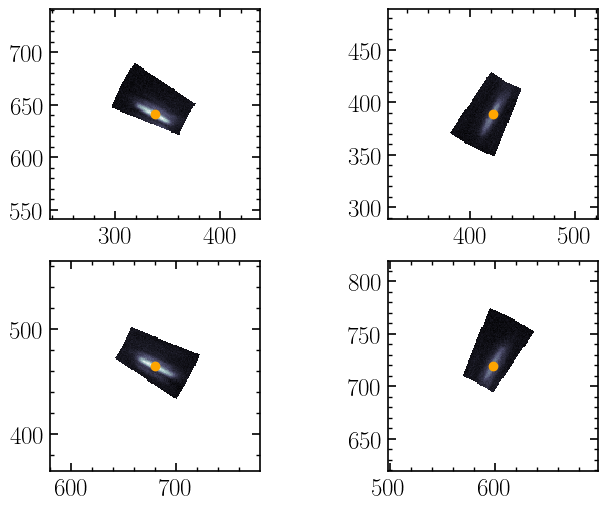

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    ax = axes.flatten()[i]
    axes.flatten()[i].imshow(sat*mask, cmap='bone', origin='lower')
    axes.flatten()[i].scatter(xs[i], ys[i], color='orange')
    ax.set_xlim(xs[i] - 100,xs[i] + 100)
    ax.set_ylim(ys[i] - 100,ys[i] + 100)

## 4: Take the average 

The final subpixel location of the star is the average of the x and y positions of each spike.

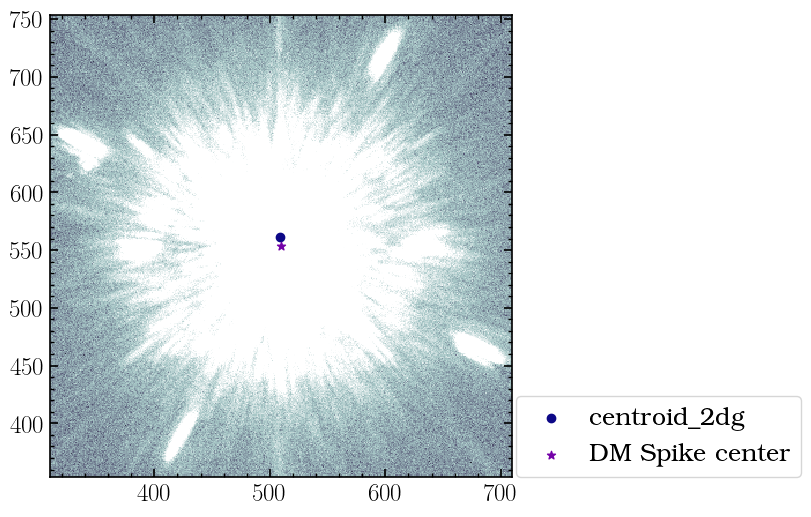

In [30]:
plt.figure()
norm = ImageNormalize(sat, interval=ZScaleInterval(),
                      stretch=SqrtStretch())
plt.imshow(sat, cmap='bone', norm=norm, origin='lower')
x1, y1 = centroid_2dg(sat)
plt.scatter(x1,y1, marker='o', label='centroid_2dg')
xfinal = np.mean(xs)
yfinal = np.mean(ys)
plt.scatter(xfinal,yfinal, marker='*', label='DM Spike center')
l = 200
plt.xlim(xfinal-l, xfinal+l)
plt.ylim(yfinal-l,yfinal+l)
plt.legend(loc=(1.01,0))
plt.show()

That looks much better to my eyes than the initial guess. We did it! 


## 5. Do all
Now we need to do it for all the images in a dataset.  Better make a function we can call.

## Remember

The location of the spikes relative to the star will scale with wavelength, so you will need to adjust the mask parameters for each dataset. Some trial and error will be needed before blindly feeding an image set to this function! Check everything!

## 6. Register images

Once you have the (x,y) locations of the star in each image, you can register (place the star in the center of the image) each image using a bicubic interpolator. I like OpenCV bc it does a more accurate bicubic interpolation than scipy (I ran into some weirdness with scipy's 2d interpolation).

Here is my function for registering images using OpenCV:

In [31]:
def ShiftImage(im, dx = None, dy = None, xc = None, yc = None, center = None,
              interp = 'bicubic', bordermode = 'constant', cval = 0, scale = 1):
    """Move an image by [dx,dy] pixels.  Uses OpenCV image processing package
    Written by Logan A. Pearce, 2022

    Dependencies: OpenCV

    Parameters:
    -----------
    im : 2d array
       2d image array
    dx, dy : None or flt
        amount of shift in x and y directions.  If None, center and xc,yc must be entered
    center : None or tuple
       (x,y) subpixel location for center of image.  If center=None,
       computes the center pixel of the image.
    xc, yc: None or flt
        if not entering a dx,dy shift, xc, yc are the location of the star in the image from which
        the shift will be computed.
    interp : str
        Interpolation mode for OpenCV.  Either nearest, bilinear, bicubic, or lanczos4.
        Default = bicubic
    bordermode : str
        How should OpenCV handle the extrapolation at the edges.  Either constant, edge, 
        symmetric, reflect, or wrap.  Default = constant
    cval : int or np.nan
        If bordermode = constant, fill edges with this value.  Default = 0
    scale : int or flt
        scale parameter for OpenCV.  Scale = 1 does not scale the image.  Default = 1

    Returns:
    --------
    2d arr 
       shifted image
    """
    import cv2
    
    if interp == 'bicubic':
        intp = cv2.INTER_CUBIC
    elif interp == 'lanczos4':
        intp = cv2.INTER_LANCZOS4
    elif interp == 'bilinear':
        intp = cv2.INTER_LINEAR
    elif interp == 'nearest':
        intp = cv2.INTER_NEAREST
    else:
        raise ValueError('Interpolation mode: please enter nearest, bilinear, bicubic, or lanczos4')
        
    if bordermode == 'constant':
        bm = cv2.BORDER_CONSTANT 
    elif bordermode == 'edge':
        bm = cv2.BORDER_REPLICATE 
    elif bordermode == 'symmetric':
        bm = cv2.BORDER_REFLECT
    elif bordermode == 'reflect':
        bm = cv2.BORDER_REFLECT_101
    elif bordermode == 'wrap':
        bm = cv2.BORDER_WRAP
    else:
        raise ValueError('Border mode: please enter constant, edge, symmetric, reflect, or wrap')
        
        
    if not dx:
        center = (0.5*((im.shape[1])-1),0.5*((im.shape[0])-1))
        dx,dy = xc-center[0],yc-center[1]
    num_rows, num_cols = im.shape[:2]
    translation_matrix = np.float32([ [1,0,dx], [0,1,dy] ])   
    imshift = cv2.warpAffine(im, translation_matrix, (num_cols, num_rows), 
                             flags=intp, borderMode=bm, borderValue=cval)  
    return imshift